In [1]:
import numpy as np
# MDP settings
M = 4
s_bar = [0.4, 0.3, 0.2, 0.1]
a_bar = 3/5
N = 50   #np.random.poisson(100) #ToDo:randomize
lambda_ = 0.5
eta = 0.025
theta_init = np.array([0.1,0.2,0.4, 0.5])


#Set the params:
dist_type = 'gaussian'

mean_vec = [5,5,5,5]
std_vec = [1,1,1,1]



In [5]:
def get_greedy_reward(dist_type, mean_vec, std_vec, N, a_bar, st, at):
    # st and at are in terms of absolute numbers in this stage
    if any(np.array(st)-np.array(at) < 0):
        greedy_reward = -np.Inf  # These actions are not permitted #ToDo: use -inf?
    else:        
        greedy_reward = 0        
        
        reward_group = np.zeros(M)
        
        for i in range(M):
            for j in range(int(at[i])):
                reward_group[i] = reward_group[i] + gaussian_expected_top_r_of_n(j+1, st[i], mean_vec[i], std_vec[i])

        greedy_reward = (1/(N*a_bar))*np.sum(reward_group)
        
    return greedy_reward


from scipy.stats import norm

def gaussian_expected_top_r_of_n(r, n, mu, sigma):
    if r<1:
        return 0
    
    method = 'approx' # Choose 'approx' or 'monte-carlo'
    
    if method == 'monte-carlo':
        Nsamples = 1000
        val = 0
        for i in range(Nsamples):
            scores = mu + sigma*np.random.randn(n,1)
            sorted_scores = np.sort(scores.flatten())
            sorted_scores = sorted_scores[::-1]
            val = val + sorted_scores[r-1]
        val = val/Nsamples
    
    elif method == 'approx':
        alpha = 0.375
        p = (r - alpha)/(n-2*alpha+1)
        val = -norm.ppf(p)
        val = sigma*val+mu
    
    return val


def process_evolution(theta_init, lambda_, eta, action_space, num_rounds = 200, decay = 0, decay_steps = 100, smallest_eta = 1e-3):
    theta = theta_init 
    A = a_bar*N

    applicants = np.zeros((num_rounds, M))
    admitted = np.zeros((num_rounds, M))
    theta_mat = np.zeros((num_rounds+1, M))
    theta_mat[0,:] = theta
    overall_utility_fg_policy = np.zeros(num_rounds)
    
    fairness_loss = np.square(np.linalg.norm(np.array(action_space)/(N*a_bar)  - s_bar, axis = 1))


    for k in range(num_rounds):
        
        if (k+1)%decay_steps == 0 and decay == 1 and eta > smallest_eta:
            eta = eta*0.75
            
        tmp_state = np.Inf*np.ones(M)

      
        state_vec = tmp_state
        
        tmp_sum = np.Inf
        while tmp_sum > N:
            group_first_idx = np.random.randint(M)
            
            for i in range(M-1):
                state_vec[(group_first_idx+i)%M] = min(N, np.random.poisson(theta[(group_first_idx+i)%M]*N)) 
            tmp_sum = 0
            for i in range(M-1):
                tmp_sum = tmp_sum + state_vec[(group_first_idx+i)%M]
                
        state_vec[(group_first_idx+M-1)%M] = N - tmp_sum

        #N1_ = state_vec[0]
        #N2_ = state_vec[1]
        #N3_ = state_vec[2]
        
        #ToDO: generalize beyond 4
        state_space_idx = state_space.index((state_vec[0], state_vec[1], state_vec[2], state_vec[3]))
        
        num_cols = greedy_reward_table.shape[1]
        if np.array_equal(greedy_reward_table[state_space_idx,:], np.zeros((1,num_cols))):
            greedy_reward_table[state_space_idx,:] = generate_row_reward(state_space_idx)
        overall_reward = greedy_reward_table[state_space_idx,:] - lambda_*fairness_loss
        
        overall_utility_fg_policy[k] = np.max(overall_reward)
        optimal_action_idx = np.argmax(overall_reward)
        optimal_action = action_space[optimal_action_idx]

        # Applicant pool evolution:
        theta = np.minimum(np.maximum(np.zeros(M), theta+eta*(np.array(optimal_action)/(a_bar*N) - state_vec/N)),np.ones(M))

        applicants[k,:] = state_vec/N
        admitted[k,:] = np.array(optimal_action)/(N*a_bar)
        theta_mat[k+1,:] = theta
    print(eta)
    return applicants, admitted, theta_mat, overall_utility_fg_policy

def generate_row_reward(state_space_idx):
    row_greedy_reward = np.zeros((1, num_cols))
        
    for j in range(greedy_reward_table.shape[1]):
        row_greedy_reward[0,j] = get_greedy_reward(dist_type, mean_vec, std_vec, N, a_bar, state_space[state_space_idx], action_space[j])


    return row_greedy_reward


In [3]:
# Generate reward table: # ToDo : generalize beyond 4.
state_space = [(x, y, z, k) for x in np.arange(N+1) for y in np.arange(N+1) for z in np.arange(N+1) for k in np.arange(N+1) if x + y+ z +k==N]
action_space = [(x, y, z, k) for x in np.arange(int(N*a_bar)+1) for y in np.arange(int(N*a_bar)+1) for z in np.arange(int(N*a_bar)+1) for k in np.arange(N*a_bar+1) if x + y+ z+k==int(N*a_bar)]
greedy_reward_table = np.zeros((len(state_space), len(action_space)))
    
greedy_reward_table.shape


(23426, 5456)

In [70]:
# Only use to generate entire table.
for i in range(len(state_space)):
    for j in range(len(action_space)):
        greedy_reward_table[i,j] = get_greedy_reward(dist_type, mean_vec, std_vec, N, a_bar, state_space[i], action_space[j])


#import matplotlib.pyplot as plt
#plt.imshow(greedy_reward_table, cmap='hot', interpolation='nearest')

In [4]:
num_rounds = 1000
theta_init = np.array([0.1,0.2,0.3,0.4])
lambda_ = 1
eta = 0.005
decay_steps = 50
decay = 0
smallest_eta = 2e-4
applicants, admitted, theta_mat, overall_rew = process_evolution(theta_init, lambda_, eta, action_space, num_rounds,decay=decay, decay_steps = decay_steps, smallest_eta = smallest_eta)

In [55]:
eta/(4/3)**15

0.00026726922020316147

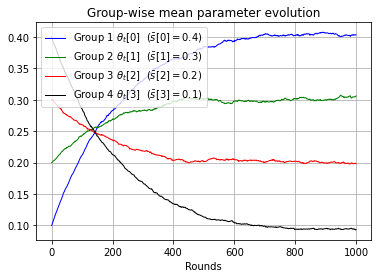

In [6]:
import matplotlib.pyplot as plt
plt.figure()

plt.plot(theta_mat[:,0], 'b', label='Group 1 ' +r'$\theta_t[0]$  ($\bar{s}[0] = $' + str(s_bar[0]) + ')', linewidth=1)
plt.plot(theta_mat[:,1], 'g', label='Group 2 ' +r'$\theta_t[1]$  ($\bar{s}[1] = $' + str(s_bar[1]) + ')', linewidth=1)
plt.plot(theta_mat[:,2], 'r', label='Group 3 ' +r'$\theta_t[2]$  ($\bar{s}[2] = $' + str(s_bar[2]) + ')', linewidth=1)
plt.plot(theta_mat[:,3], 'k', label='Group 4 ' +r'$\theta_t[3]$  ($\bar{s}[3] = $' + str(s_bar[3]) + ')', linewidth=1)

plt.title('Group-wise mean parameter evolution')
plt.grid()
plt.xlabel('Rounds')
plt.legend()


In [58]:
plt.savefig('four_groups.pdf')

<Figure size 432x288 with 0 Axes>

In [49]:
idx = 777
state_tmp = state_space[idx]
greedy_reward_at_st = greedy_reward_table[idx,:]
max_idx = np.argmax(greedy_reward_at_st)
opt_action_tmp = action_space[max_idx]

print(np.array(state_tmp)) 
print(np.array(opt_action_tmp))
print(np.array(state_tmp)/N) 
print(np.array(opt_action_tmp)/(N*a_bar))


[18 12 20]
[7 5 8]
[0.36 0.24 0.4 ]
[0.35 0.25 0.4 ]


<IPython.core.display.Javascript object>


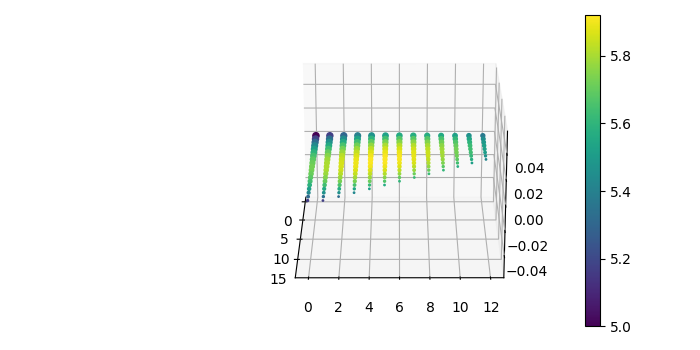

In [55]:
%matplotlib notebook
plt.rcParams["figure.figsize"] = [7.00, 3.50]

plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = [item[0] for item in action_space]
y = [item[1] for item in action_space]
z = [item[2] for item in action_space]
c = greedy_reward_at_st
plt.scatter(x, y, z, c, alpha=1)
plt.colorbar()
plt.show()

In [54]:
z

[20,
 19,
 18,
 17,
 16,
 15,
 14,
 13,
 12,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1,
 0,
 19,
 18,
 17,
 16,
 15,
 14,
 13,
 12,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1,
 0,
 18,
 17,
 16,
 15,
 14,
 13,
 12,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1,
 0,
 17,
 16,
 15,
 14,
 13,
 12,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1,
 0,
 16,
 15,
 14,
 13,
 12,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1,
 0,
 15,
 14,
 13,
 12,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1,
 0,
 14,
 13,
 12,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1,
 0,
 13,
 12,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1,
 0,
 12,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1,
 0,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1,
 0,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1,
 0,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1,
 0,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1,
 0,
 7,
 6,
 5,
 4,
 3,
 2,
 1,
 0,
 6,
 5,
 4,
 3,
 2,
 1,
 0,
 5,
 4,
 3,
 2,
 1,
 0,
 4,
 3,
 2,
 1,
 0,
 3,
 2,
 1,
 0,
 2,
 1,
 0,
 1,
 0,
 0]